In [3]:
!/opt/bin/nvidia-smi
!nvcc --version

Mon Apr  6 11:39:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [13]:
!wget 'https://storage.googleapis.com/sherlock_datasets/CASIA_TrainTest_ELA.zip'

--2020-04-06 11:48:51--  https://storage.googleapis.com/sherlock_datasets/CASIA_TrainTest_ELA.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1388053615 (1.3G) [application/zip]
Saving to: ‘CASIA_TrainTest_ELA.zip.1’

CASIA_TrainTest_ELA 100%[===================>]   1.29G  42.9MB/s    in 36s     

2020-04-06 11:49:29 (36.8 MB/s) - ‘CASIA_TrainTest_ELA.zip.1’ saved [1388053615/1388053615]



In [0]:
!unzip -o -q CASIA_TrainTest_ELA.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [17]:
path = Path("/root/.fastai/data/CASIA-V2_ELA"); path

PosixPath('/root/.fastai/data/CASIA-V2_ELA')

In [0]:
path_to_test = Path("/root/.fastai/data/CASIA-V2_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 64
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid_pct=0.2, 
                                  ds_tfms = tfms, size=size, bs=bs)


In [21]:
data

ImageDataBunch;

Train: LabelList (10092 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /root/.fastai/data/CASIA-V2_ELA;

Valid: LabelList (2522 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Authentic,Tampered,Tampered,Authentic,Tampered
Path: /root/.fastai/data/CASIA-V2_ELA;

Test: None

In [0]:
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [0]:
print('Transforms = ', len(tfms))
print(data.classes)
data

Transforms =  2
['Authentic', 'Tampered']


ImageDataBunch;

Train: LabelList (7605 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /root/.fastai/data/CASIA_ELA;

Valid: LabelList (4163 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /root/.fastai/data/CASIA_ELA;

Test: None

In [0]:
data.show_batch(rows=5, figsize=(15,15))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# learn.model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(10)
learn.save('ela-stage-1')
# exportStageTo(learn, path)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.411356,0.253191,0.903675,0.096325,05:36
1,0.316209,0.218511,0.904156,0.095844,05:33
2,0.249360,0.188869,0.910641,0.089359,05:32
3,0.226171,0.219120,0.908960,0.091040,05:33
4,0.197083,0.164233,0.926495,0.073505,05:32
5,0.186174,0.149653,0.934182,0.065818,05:33
6,0.167941,0.148591,0.934182,0.065818,05:29
7,0.158238,0.145024,0.934422,0.065578,05:30
8,0.153024,0.139521,0.936824,0.063176,05:30
9,0.149242,0.139459,0.939467,0.060533,05:34


NameError: ignored

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

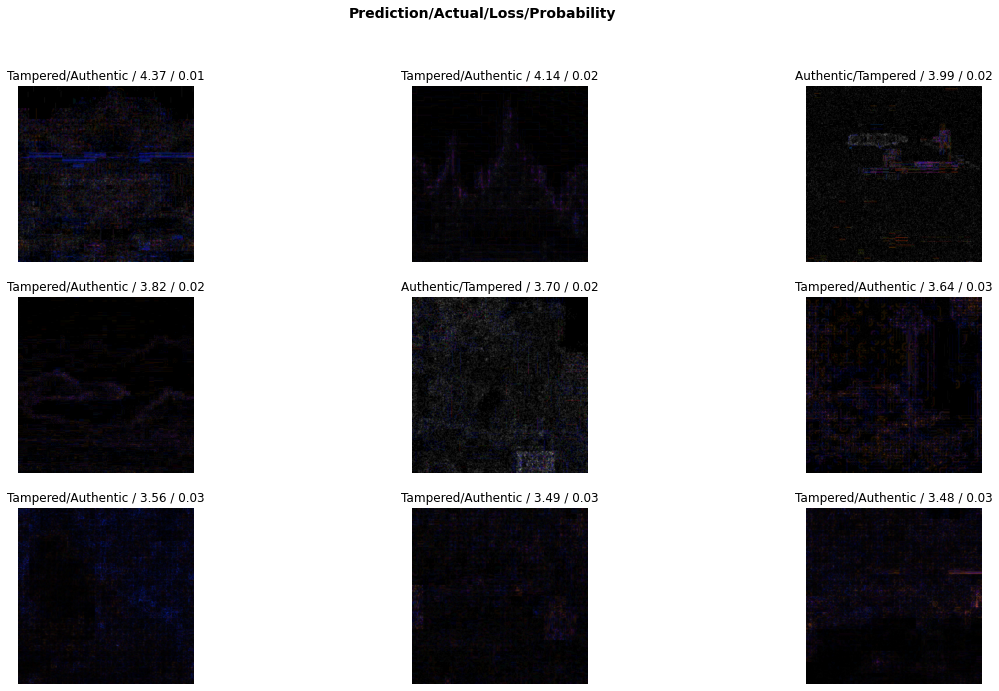

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

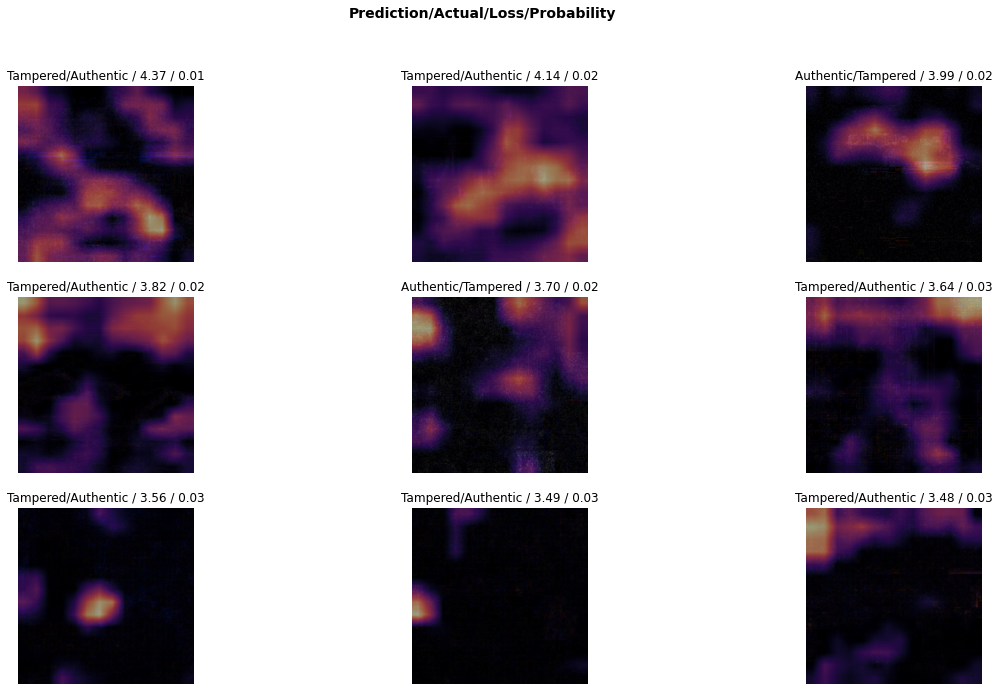

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

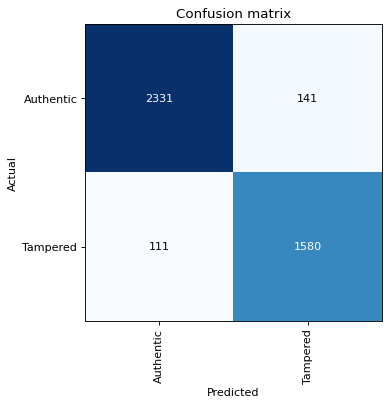

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [0]:
losses

tensor([6.3726, 4.5531, 4.2979,  ..., -0.0000, -0.0000, -0.0000])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


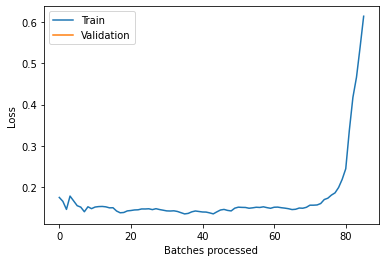

In [0]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.45E-06


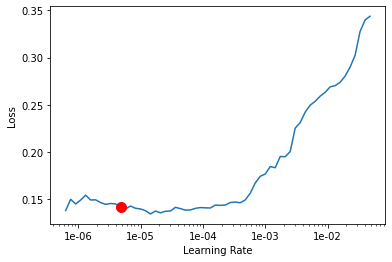

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

learn.fit_one_cycle(30, max_lr=slice(1e-4,1e-5))

learn.save('ela-stage-2')

# exportStageTo(learn, path)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.148594,0.137135,0.940428,0.059572,05:59
1,0.137840,0.137234,0.941629,0.058371,06:01
2,0.131325,0.135422,0.942589,0.057411,05:59
3,0.122354,0.150556,0.937545,0.062455,06:00
4,0.123866,0.130956,0.944511,0.055489,06:01
5,0.116253,0.155891,0.937785,0.062215,06:03
6,0.114977,0.117138,0.948355,0.051645,06:02
7,0.118647,0.156215,0.933702,0.066298,06:02
8,0.106561,0.120074,0.954360,0.045640,06:08
9,0.105416,0.128817,0.949556,0.050444,06:03


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

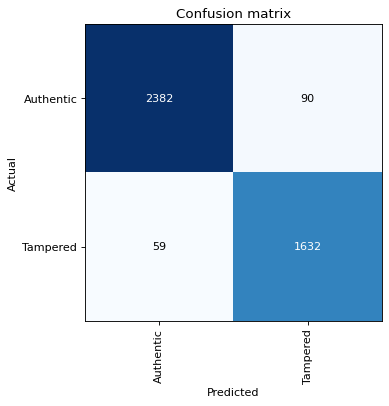

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

Get Predictions and accuracy on the test dataset

In [0]:
learn = load_learner(path)

In [0]:
path = '/content/data/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/content/data/CASIA_ELA/Test/Tampered/
/content/data/CASIA_ELA/Test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [0]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
470/502. Accuracy = 93.63%
Images Classified As Tampered
323/344. Accuracy = 93.90%


In [0]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 93.744%


Predict on a single image

In [0]:
img = open_image('/content/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png')

In [0]:
pred_class,pred_idx,confidence = learn.predict(img); pred_class

Category Tampered

Create a heatmap of the image

In [0]:
!pip install Pillow --upgrade

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


In [0]:
!pip install fastai2

In [0]:
from fastai.callbacks.hooks import *
from fastai2.vision.all import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
fn = Path("/root/.fastai/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png")

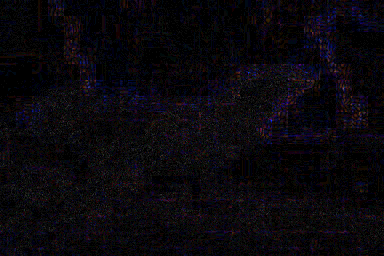

In [0]:
x = PILImage.create(fn); x